In [1]:
#libraries need to be installed 

In [2]:
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os, time 
from skimage import color
from skimage import io
import cv2 
import glob 
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.backend.tensorflow_backend import set_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
# lets check gpu available 
tf.__version__
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from functions import image_data

In [5]:
# configuring the usage of gpu
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
config.gpu_options.visible_device_list = "0" 
set_session(tf.compat.v1.Session(config=config))   

In [6]:
X_seg_train = image_data('keras_png_slices_train')

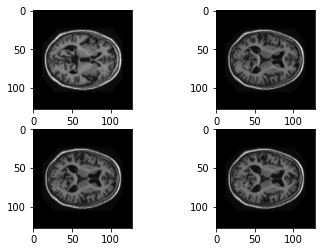

In [7]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X_seg_train[1],cmap="gray")
axs[0, 1].imshow(X_seg_train[2],cmap="gray")
axs[1, 0].imshow(X_seg_train[3],cmap="gray")
axs[1, 1].imshow(X_seg_train[4],cmap="gray")

In [8]:
# reshape data to [8000, 128, 128, 1]
train_images = (X_seg_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

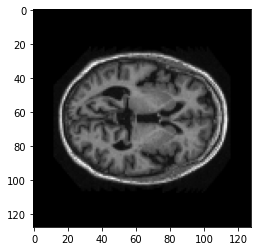

In [9]:
plt.imshow(train_images[1],cmap='gray')

In [10]:
BUFFER_SIZE = 8000
BATCH_SIZE = 50

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
from functions import make_generator_model

In [13]:
# generator model generate image with noise before traning

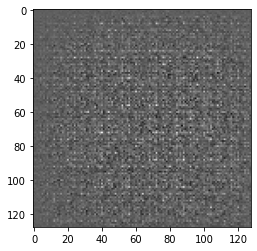

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

In [16]:
from functions import make_discriminator_model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00051399]], shape=(1, 1), dtype=float32)


In [17]:
from functions import generator_loss,discriminator_loss

In [18]:
# cross entropy function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
from functions import train_step,train

In [23]:
from IPython import display
from functions import generate_and_save_images

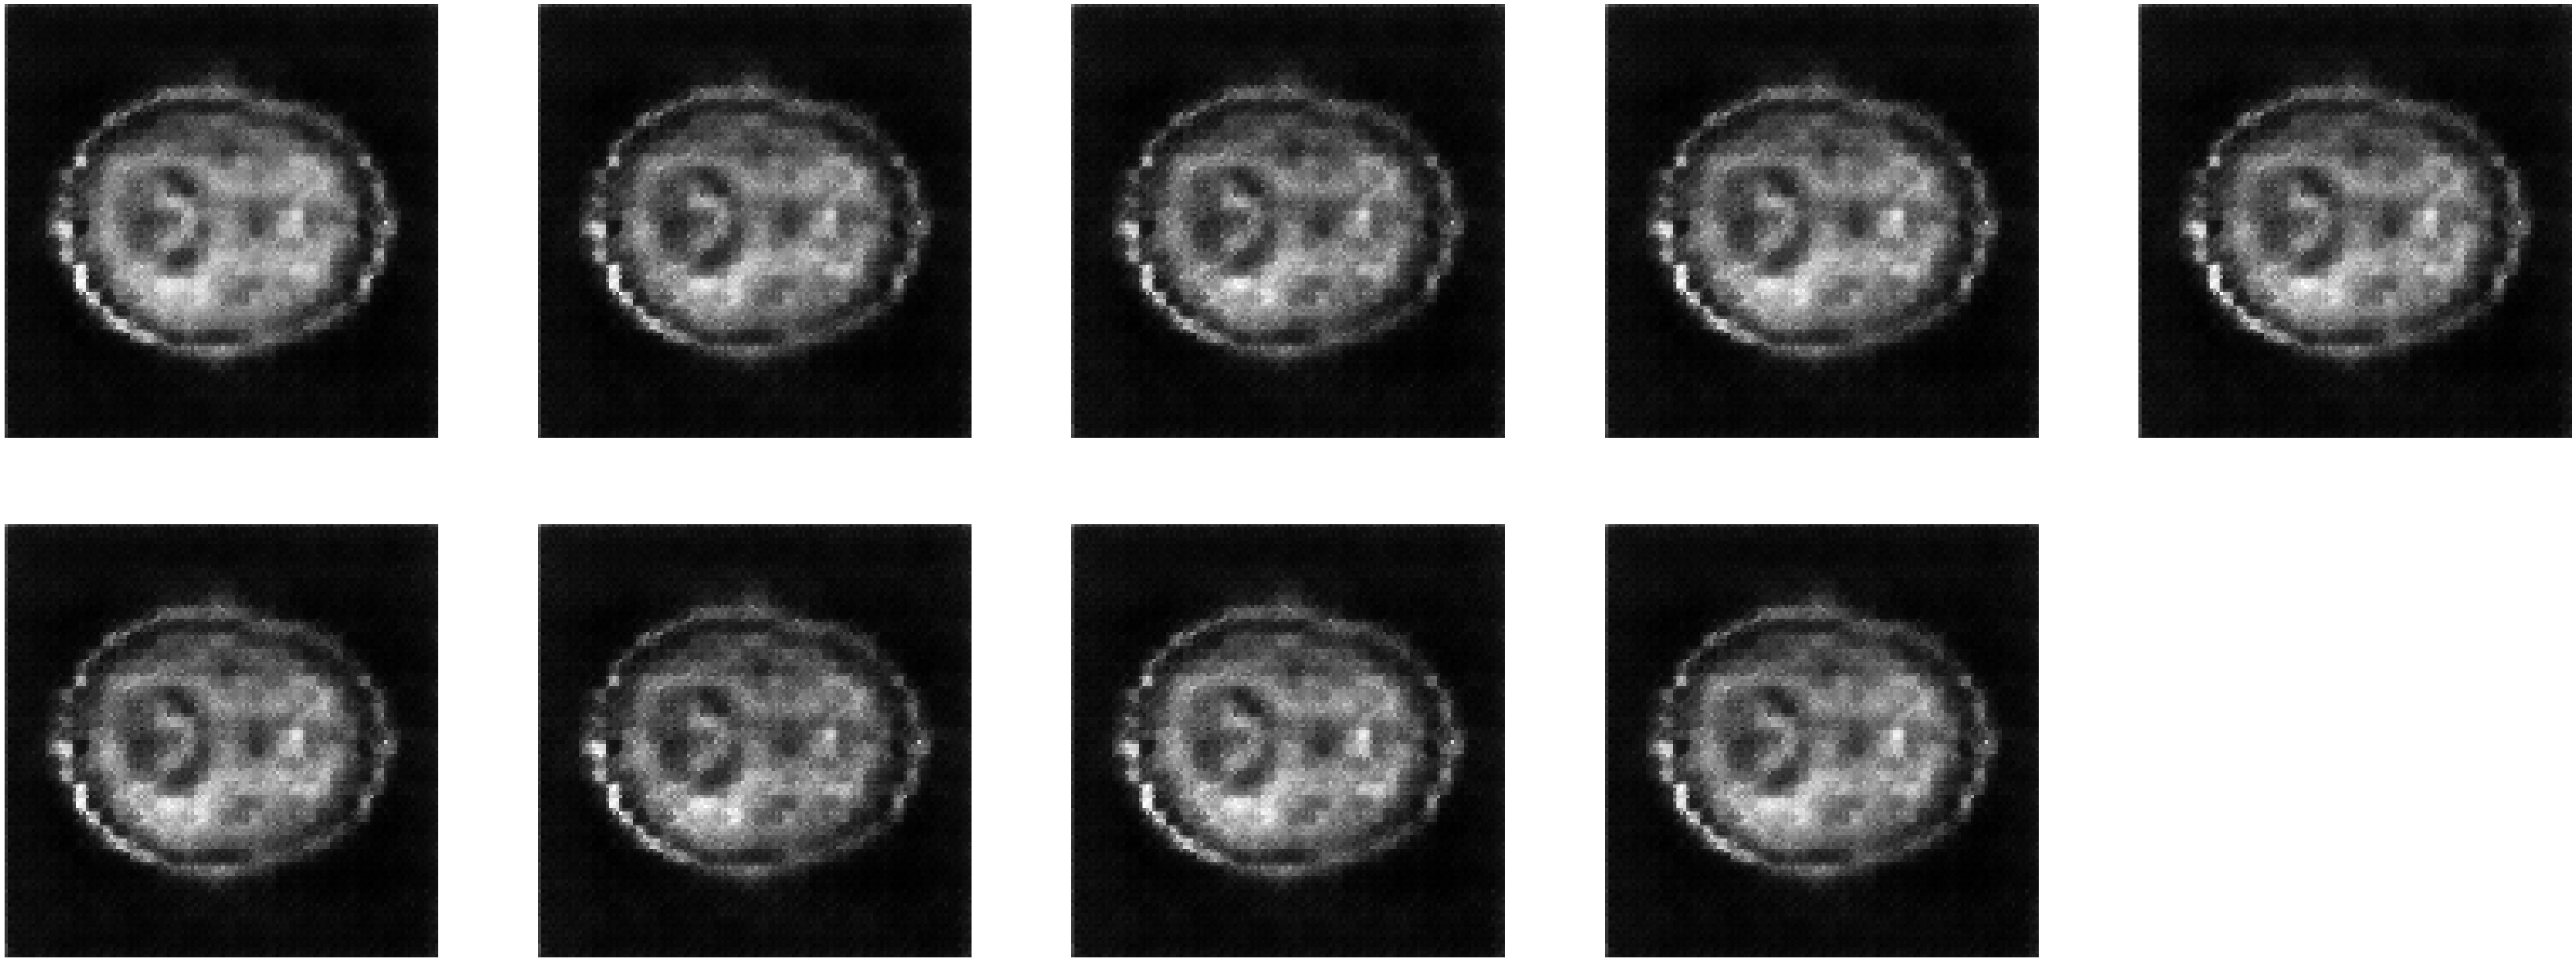

Time for epoch 2 is 88.41145443916321 sec


In [ ]:
for epoch in range(5):
    start = time.time()
    for image_batch in train_dataset:
        train_step(image_batch,BATCH_SIZE=128,noise_dim=100,generator=generator,discriminator=discriminator,generator_optimizer
                   =generator_optimizer,discriminator_optimizer=discriminator_optimizer)
    # Produce images 
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
# Display a single image using the epoch number
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)